In [21]:
import xarray as xr
# import wrf
# from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import reduce

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

file_dir = '/Users/leec813/OneDrive - PNNL/Documents/mmc/ml/trim_wrfstat/'

# drop first N hours of data in each wrfstat file
spin_up = 3

wrfstat = xr.open_dataset(file_dir+'wrfstat1_d01_2019-07-04_12:00:00.nc')

wrfstat['CSP_WS'] = np.sqrt(wrfstat['CSP_U']**2 + wrfstat['CSP_V']**2)

time_thres = wrfstat['XTIME'].min().values + np.timedelta64(spin_up, 'h')

wrfstat = wrfstat.where(wrfstat['XTIME'] >= time_thres, drop=True)

In [22]:
wrfstat

<xarray.Dataset>
Dimensions:      (Time: 73, bottom_top: 16)
Dimensions without coordinates: Time, bottom_top
Data variables: (12/32)
    CSP_Z        (Time, bottom_top) float32 15.52 46.54 77.52 ... 454.8 486.0
    CSP_U        (Time, bottom_top) float32 2.398 2.749 2.879 ... 4.065 4.065
    CSP_V        (Time, bottom_top) float32 5.862 6.724 7.071 ... 4.727 4.738
    CSP_P        (Time, bottom_top) float32 9.728e+04 9.694e+04 ... 9.232e+04
    CSP_THV      (Time, bottom_top) float32 305.3 305.1 305.0 ... 311.1 311.1
    CSP_TH       (Time, bottom_top) float32 302.0 301.9 301.8 ... 308.1 308.1
    ...           ...
    CST_PRECT    (Time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    CST_CLDTOT   (Time) float32 0.00121 0.001021 0.0009592 ... 0.0 0.0 0.0
    CST_LWP      (Time) float32 2.136e-06 1.973e-06 1.734e-06 ... 0.0 0.0 0.0
    XTIME        (Time) datetime64[ns] 2019-07-04T15:00:00 ... 2019-07-05T03:...
    Times        (Time) object b'2019-07-04_15:00:00' ... b'2019-07-05_03:00:00'
    CSP_WS       (Time, bottom_top) float32 6.333 7.264 7.635 ... 6.235 6.243
Attributes: (12/96)
    TITLE:                                  OUTPUT FROM WRF V3.8.1 MODEL
    START_DATE:                            2019-07-04_12:00:00
    WEST-EAST_GRID_DIMENSION:              251
    SOUTH-NORTH_GRID_DIMENSION:            251
    BOTTOM-TOP_GRID_DIMENSION:             227
    DX:                                    100.0
    ...                                    ...
    config_aerosol:                        NA
    config_forecast_time:                  15.0 h
    config_boundary_method:                Periodic
    config_microphysics:                   Thompson (mp_physics=8)
    config_nickname:                       runlas20190704v1nols
    simulation_origin_host:                cumulus-login2.ccs.ornl.gov

In [23]:
df1 = wrfstat['CSP_U'][:, 0:2].to_dataframe()
df2 = wrfstat['CSP_V'][:, 0:2].to_dataframe()
df3 = wrfstat['CSP_P'][:, 0:2].to_dataframe()
df4 = wrfstat['CSP_WS'][:, 2].to_dataframe()

combine_df = reduce(lambda left, right: pd.merge(left, right, 
                                                 left_index=True, right_index=True), [df1, df2, df3])

data_df = pd.merge(combine_df.unstack(), df4, left_index=True, right_index=True)

<ipython-input-23-b05a79e008eb>:9: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  data_df = pd.merge(combine_df.unstack(), df4, left_index=True, right_index=True)


In [24]:
X = data_df.drop(['CSP_WS'], axis=1)
y = data_df['CSP_WS']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [26]:
X_train.head()

,"(CSP_U, 0)","(CSP_U, 1)","(CSP_V, 0)","(CSP_V, 1)","(CSP_P, 0)","(CSP_P, 1)"
Time,,,,,,
15,3.622029,4.157128,5.404500,6.191604,97286.953125,96945.968750
63,1.486085,2.898032,1.701060,3.314036,97311.914062,96971.250000
4,2.716528,3.119725,5.652938,6.483307,97281.203125,96940.304688
30,4.211799,4.852827,4.866078,5.591935,97297.546875,96956.640625
64,1.323497,2.860084,1.514287,3.270901,97311.953125,96971.257812


In [27]:
regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

In [28]:
regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
pd.DataFrame(regressor.feature_importances_.reshape(1, -1), columns=X.columns)

,"(CSP_U, 0)","(CSP_U, 1)","(CSP_V, 0)","(CSP_V, 1)","(CSP_P, 0)","(CSP_P, 1)"
0,0.013122,0.0005,0.984394,0.000273,0.001711,0.0


In [30]:
y_pred = regressor.predict(X_test)

/Users/leec813/opt/anaconda3/envs/mmc-sgp/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [34]:
mean_squared_error(y_test, y_pred)

0.0057080947

In [35]:
y_pred

array([5.1800838, 6.534087 , 7.9827456, 5.9776397, 7.487581 , 7.487581 ,
       7.565172 , 5.1800838, 7.6123376, 5.1800838, 6.6190443, 7.544184 ,
       7.676523 , 5.1800838, 5.137813 , 8.069691 , 6.1242704, 7.6123376,
       6.987334 ], dtype=float32)

In [36]:
y_test

Time
70    5.199021
48    6.333999
16    7.903717
54    5.912901
8     7.556892
9     7.572552
10    7.611022
68    5.165732
0     7.634803
71    5.214731
45    6.554070
34    7.457126
14    7.811152
72    5.229398
67    5.152188
22    8.127268
50    6.188447
2     7.591665
40    6.953268
Name: CSP_WS, dtype: float32

In [48]:
combine_df.unstack()

CSP_U               CSP_V                   CSP_P              
bottom_top         0         1         0         1             0             1
Time                                                                          
0           2.397911  2.749393  5.861617  6.723990  97279.671875  96938.804688
1           2.473312  2.837871  5.817113  6.666911  97280.031250  96939.156250
2           2.554690  2.929956  5.766158  6.607211  97280.406250  96939.531250
3           2.644375  3.034648  5.700789  6.538343  97280.796875  96939.906250
4           2.716528  3.119725  5.652938  6.483307  97281.203125  96940.304688
...              ...       ...       ...       ...           ...           ...
68          0.797065  2.769485  0.911494  3.167735  97312.070312  96971.257812
69          0.694204  2.749843  0.792998  3.142901  97312.085938  96971.257812
70          0.604595  2.730737  0.691056  3.119602  97312.117188  96971.257812
71          0.529070  2.711570  0.604122  3.096205  97312.117188  96971.257812
72          0.464118  2.693259  0.529881  3.072651  97312.132812  96971.257812

[73 rows x 6 columns]

<ipython-input-53-03d9e6e92aba>:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  pd.merge(combine_df.unstack(), df4, left_index=True, right_index=True)


,"(CSP_U, 0)","(CSP_U, 1)","(CSP_V, 0)","(CSP_V, 1)","(CSP_P, 0)","(CSP_P, 1)",CSP_WS
Time,,,,,,,
0,2.397911,2.749393,5.861617,6.723990,97279.671875,96938.804688,7.634803
1,2.473312,2.837871,5.817113,6.666911,97280.031250,96939.156250,7.613231
2,2.554690,2.929956,5.766158,6.607211,97280.406250,96939.531250,7.591665
3,2.644375,3.034648,5.700789,6.538343,97280.796875,96939.906250,7.579397
4,2.716528,3.119725,5.652938,6.483307,97281.203125,96940.304688,7.565524
...,...,...,...,...,...,...,...
68,0.797065,2.769485,0.911494,3.167735,97312.070312,96971.257812,5.165732
69,0.694204,2.749843,0.792998,3.142901,97312.085938,96971.257812,5.182229
70,0.604595,2.730737,0.691056,3.119602,97312.117188,96971.257812,5.199021


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [49]:
wrfstat['CSP_Z'][12, :]

<xarray.DataArray 'CSP_Z' (bottom_top: 16)>
array([ 15.467741,  46.384872,  77.26348 , 108.102905, 138.89336 , 169.65231 ,
       200.39455 , 231.12186 , 261.84708 , 292.55563 , 323.24063 , 353.91492 ,
       384.58246 , 415.22272 , 445.83286 , 476.42603 ], dtype=float32)
Dimensions without coordinates: bottom_top
Attributes:
    FieldType:    104
    MemoryOrder:  Z  
    description:  Half level height
    units:        m
    stagger:

In [46]:
wrfstat['CSP_Z']

<xarray.DataArray 'CSP_Z' (Time: 91, bottom_top: 16)>
array([[  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [ 15.36411 ,  46.08309 ,  76.78076 , ..., 414.03165 , 444.6944  ,
        475.37198 ],
       [ 15.378009,  46.121056,  76.835655, ..., 414.05875 , 444.72174 ,
        475.39923 ],
       ...,
       [ 15.630575,  47.008297,  78.512955, ..., 423.78375 , 454.98846 ,
        486.13135 ],
       [ 15.612292,  46.965866,  78.46261 , ..., 423.7033  , 454.90594 ,
        486.0467  ],
       [ 15.594632,  46.924496,  78.41307 , ..., 423.62338 , 454.82373 ,
        485.96234 ]], dtype=float32)
Dimensions without coordinates: Time, bottom_top
Attributes:
    FieldType:    104
    MemoryOrder:  Z  
    description:  Half level height
    units:        m
    stagger:

In [6]:
wrfstat['CSP_U']

<xarray.DataArray 'CSP_U' (Time: 73, bottom_top: 16)>
array([[2.397911  , 2.749393  , 2.8794065 , ..., 4.657054  , 5.2095037 ,
        5.920586  ],
       [2.4733124 , 2.837871  , 2.973864  , ..., 4.567459  , 5.056035  ,
        5.685382  ],
       [2.5546901 , 2.9299564 , 3.0692937 , ..., 4.504735  , 4.9359684 ,
        5.4895716 ],
       ...,
       [0.6045951 , 2.7307374 , 3.4260933 , ..., 4.061365  , 4.06237   ,
        4.0611215 ],
       [0.5290705 , 2.71157   , 3.4361234 , ..., 4.061823  , 4.063842  ,
        4.0630407 ],
       [0.46411818, 2.693259  , 3.446589  , ..., 4.061852  , 4.0649695 ,
        4.0653296 ]], dtype=float32)
Dimensions without coordinates: Time, bottom_top
Attributes:
    FieldType:    104
    MemoryOrder:  Z  
    description:  Zonal wind
    units:        m/s
    stagger:

In [43]:
wrfstat['CSP_WS'][:, 2]

<xarray.DataArray 'CSP_WS' (Time: 91)>
array([0.       , 6.398809 , 5.822668 , 5.91179  , 6.068026 , 6.26901  ,
       6.6686897, 7.2505527, 7.8000293, 8.111984 , 8.115377 , 7.9947925,
       7.9100704, 7.8447165, 7.782302 , 7.726912 , 7.6944633, 7.673194 ,
       7.634803 , 7.613231 , 7.5916653, 7.5793967, 7.5655236, 7.532632 ,
       7.522366 , 7.553053 , 7.5568924, 7.5725517, 7.611022 , 7.6575437,
       7.683576 , 7.7279925, 7.8111515, 7.853967 , 7.9037166, 7.97685  ,
       8.024804 , 8.089989 , 8.112503 , 8.109121 , 8.127268 , 8.138001 ,
       8.139242 , 8.119034 , 8.062835 , 8.007867 , 7.976245 , 7.906758 ,
       7.8197265, 7.6999435, 7.608535 , 7.54417  , 7.457126 , 7.339674 ,
       7.2169976, 7.1403728, 7.078677 , 7.011957 , 6.953268 , 6.8911705,
       6.7849336, 6.6790147, 6.6187577, 6.5540705, 6.494815 , 6.4068446,
       6.3339987, 6.2678723, 6.188447 , 6.1248765, 6.047061 , 5.979132 ,
       5.912901 , 5.823318 , 5.715456 , 5.605354 , 5.4607654, 5.317199 ,
       5.2446923, 5.191386 , 5.152075 , 5.1307015, 5.122023 , 5.124575 ,
       5.137605 , 5.1521883, 5.165732 , 5.182229 , 5.1990213, 5.214731 ,
       5.229398 ], dtype=float32)
Dimensions without coordinates: Time

In [32]:
wrfstat['CSP_WS'] = np.sqrt(wrfstat['CSP_U']**2 + wrfstat['CSP_V']**2)

In [33]:
wrfstat['CSP_WS']

<xarray.DataArray 'CSP_WS' (Time: 91, bottom_top: 16)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.5058637 ,  4.8254876 ,  6.398809  , ..., 15.902366  ,
        16.296     , 16.50157   ],
       [ 4.0557113 ,  4.857498  ,  5.822668  , ..., 15.907993  ,
        16.289005  , 16.50517   ],
       ...,
       [ 0.91820115,  4.1459427 ,  5.1990213 , ...,  6.2226353 ,
         6.2327914 ,  6.2400875 ],
       [ 0.8030435 ,  4.1157136 ,  5.214731  , ...,  6.222988  ,
         6.233911  ,  6.2413673 ],
       [ 0.7044005 ,  4.085931  ,  5.229398  , ...,  6.2232723 ,
         6.234817  ,  6.2432384 ]], dtype=float32)
Dimensions without coordinates: Time, bottom_top

In [34]:
wrfstat['CSP_U']

<xarray.DataArray 'CSP_U' (Time: 91, bottom_top: 16)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [-0.213815, -0.247153, -0.224582, ...,  9.342006, 10.26333 , 11.032629],
       [-0.179258, -0.181704, -0.146797, ...,  9.322582, 10.283904, 11.002962],
       ...,
       [ 0.604595,  2.730737,  3.426093, ...,  4.061365,  4.06237 ,  4.061121],
       [ 0.52907 ,  2.71157 ,  3.436123, ...,  4.061823,  4.063842,  4.063041],
       [ 0.464118,  2.693259,  3.446589, ...,  4.061852,  4.06497 ,  4.06533 ]],
      dtype=float32)
Dimensions without coordinates: Time, bottom_top
Attributes:
    FieldType:    104
    MemoryOrder:  Z  
    description:  Zonal wind
    units:        m/s
    stagger:

In [35]:
wrfstat['CSP_V']

<xarray.DataArray 'CSP_V' (Time: 91, bottom_top: 16)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 3.499337,  4.819154,  6.394866, ..., 12.869039, 12.657947, 12.271224],
       [ 4.051748,  4.854098,  5.820817, ..., 12.890062, 12.632219, 12.302661],
       ...,
       [ 0.691056,  3.119602,  3.910461, ...,  4.714499,  4.727033,  4.73772 ],
       [ 0.604122,  3.096205,  3.92256 , ...,  4.71457 ,  4.727244,  4.73776 ],
       [ 0.529881,  3.072651,  3.93289 , ...,  4.714921,  4.727469,  4.738262]],
      dtype=float32)
Dimensions without coordinates: Time, bottom_top
Attributes:
    FieldType:    104
    MemoryOrder:  Z  
    description:  Meridional wind
    units:        m/s
    stagger:

In [19]:
file_dir

'/Users/leec813/OneDrive - PNNL/Documents/mmc/ml/trim_wrfstat/'

In [20]:
test = xr.open_dataset(file_dir+'wrfstat2_d01_2019-07-04_12:00:00.nc')
test['CSP_Z'][1]

<xarray.DataArray 'CSP_Z' (bottom_top: 16)>
array([ 15.364113,  46.083107,  76.78072 , 107.46885 , 138.13585 , 168.79027 ,
       199.44606 , 230.0929  , 260.73953 , 291.38995 , 322.03967 , 352.6881  ,
       383.35645 , 414.02655 , 444.68732 , 475.3623  ], dtype=float32)
Dimensions without coordinates: bottom_top
Attributes:
    FieldType:    104
    MemoryOrder:  Z  
    description:  Half level height
    units:        m
    stagger:

In [21]:
test = xr.open_dataset(file_dir+'wrfstat1_d01_2018-05-22_12:00:00.nc')
test['CSP_Z'][1]

<xarray.DataArray 'CSP_Z' (bottom_top: 16)>
array([ 15.330681,  45.999046,  76.6363  , 107.21609 , 137.75938 , 168.29918 ,
       198.86047 , 229.41972 , 259.97025 , 290.51398 , 321.04315 , 351.56757 ,
       382.0916  , 412.6131  , 443.13745 , 473.66754 ], dtype=float32)
Dimensions without coordinates: bottom_top
Attributes:
    FieldType:    104
    MemoryOrder:  Z  
    description:  Half level height
    units:        m
    stagger:

In [24]:
test['WS'] = test

<xarray.Dataset>
Dimensions:      (Time: 91, bottom_top: 16)
Dimensions without coordinates: Time, bottom_top
Data variables: (12/31)
    CSP_Z        (Time, bottom_top) float32 0.0 0.0 0.0 ... 419.2 450.2 481.1
    CSP_U        (Time, bottom_top) float32 0.0 0.0 0.0 ... 2.192 2.192 2.191
    CSP_V        (Time, bottom_top) float32 0.0 0.0 0.0 ... 3.671 3.679 3.685
    CSP_P        (Time, bottom_top) float32 0.0 0.0 0.0 ... 9.312e+04 9.279e+04
    CSP_THV      (Time, bottom_top) float32 0.0 0.0 0.0 ... 307.2 307.2 307.2
    CSP_TH       (Time, bottom_top) float32 0.0 0.0 0.0 ... 305.2 305.2 305.2
    ...           ...
    CST_PS       (Time) float32 0.0 9.777e+04 9.777e+04 ... 9.781e+04 9.781e+04
    CST_PRECT    (Time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    CST_CLDTOT   (Time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    CST_LWP      (Time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    XTIME        (Time) datetime64[ns] 2018-05-22T12:00:00 ... 2018-05-23T03:...
    Times        (Time) |S19 b'2018-05-22_12:00:00' ... b'2018-05-23_03:00:00'
Attributes: (12/97)
    TITLE:                                  OUTPUT FROM WRF V3.8.1 MODEL
    START_DATE:                            2018-05-22_12:00:00
    WEST-EAST_GRID_DIMENSION:              251
    SOUTH-NORTH_GRID_DIMENSION:            251
    BOTTOM-TOP_GRID_DIMENSION:             227
    DX:                                    100.0
    ...                                    ...
    config_aerosol:                        NA
    config_forecast_time:                  15.0 h
    config_boundary_method:                Periodic
    config_microphysics:                   Thompson (mp_physics=8)
    config_nickname:                       runlas20180522v1nols
    simulation_origin_host:                cumulus-login2.ccs.ornl.gov

In [5]:
import xgboost as xgb

In [7]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [8]:
dataset = loadtxt('/Users/leec813/Downloads/pima-indians-diabetes.csv', delimiter=",")

In [9]:
dataset

array([[  6.   , 148.   ,  72.   , ...,   0.627,  50.   ,   1.   ],
       [  1.   ,  85.   ,  66.   , ...,   0.351,  31.   ,   0.   ],
       [  8.   , 183.   ,  64.   , ...,   0.672,  32.   ,   1.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,   0.245,  30.   ,   0.   ],
       [  1.   , 126.   ,  60.   , ...,   0.349,  47.   ,   1.   ],
       [  1.   ,  93.   ,  70.   , ...,   0.315,  23.   ,   0.   ]])

In [14]:
dataset.shape

(768, 9)

In [10]:
X = dataset[:,0:8]
Y = dataset[:,8]

In [13]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[14:10:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 74.02%


/Users/leec813/opt/anaconda3/envs/mmc-sgp/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [17]:
X_train.shape

(514, 8)

In [6]:
dtrain = xgb.DMatrix('demo/data/agaricus.txt.train')
dtest = xgb.DMatrix('demo/data/agaricus.txt.test')

XGBoostError: [12:53:12] ../dmlc-core/src/io/local_filesys.cc:104: LocalFileSystem.ListDirectory demo/data error: No such file or directory
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001185db074 dmlc::LogMessageFatal::~LogMessageFatal() + 116
  [bt] (1) 2   libxgboost.dylib                    0x00000001187d43d7 dmlc::io::LocalFileSystem::ListDirectory(dmlc::io::URI const&, std::__1::vector<dmlc::io::FileInfo, std::__1::allocator<dmlc::io::FileInfo> >*) + 439
  [bt] (2) 3   libxgboost.dylib                    0x00000001187c2f43 dmlc::io::InputSplitBase::ConvertToURIs(std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > const&) + 563
  [bt] (3) 4   libxgboost.dylib                    0x00000001187c20b4 dmlc::io::InputSplitBase::InitInputFileInfo(std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > const&, bool) + 68
  [bt] (4) 5   libxgboost.dylib                    0x00000001187c1e94 dmlc::io::InputSplitBase::Init(dmlc::io::FileSystem*, char const*, unsigned long, bool) + 180
  [bt] (5) 6   libxgboost.dylib                    0x00000001187b869e dmlc::InputSplit::Create(char const*, char const*, unsigned int, unsigned int, char const*, bool, int, unsigned long, bool) + 958
  [bt] (6) 7   libxgboost.dylib                    0x00000001187b8f12 dmlc::InputSplit::Create(char const*, unsigned int, unsigned int, char const*) + 34
  [bt] (7) 8   libxgboost.dylib                    0x000000011877852e dmlc::Parser<unsigned int, float>* dmlc::data::CreateLibSVMParser<unsigned int, float>(std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > const&, std::__1::map<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::less<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > >, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > const, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > > > > const&, unsigned int, unsigned int) + 46
  [bt] (8) 9   libxgboost.dylib                    0x000000011877a09b dmlc::Parser<unsigned int, float>* dmlc::data::CreateParser_<unsigned int, float>(char const*, unsigned int, unsigned int, char const*) + 491



In [74]:
test['bottom_top']

<xarray.DataArray 'bottom_top' (bottom_top: 16)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])
Dimensions without coordinates: bottom_top

In [75]:
test['CSP_V2']

<xarray.DataArray 'CSP_V2' (Time: 91, bottom_top: 16)>
array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.008954, 0.008941, 0.015093, ..., 0.000359, 0.000258, 0.000172],
       [0.004606, 0.006312, 0.00864 , ..., 0.001434, 0.001034, 0.00071 ],
       ...,
       [0.011345, 0.0442  , 0.037546, ..., 0.028271, 0.028878, 0.029403],
       [0.010817, 0.044471, 0.036886, ..., 0.026335, 0.027327, 0.028526],
       [0.011288, 0.037828, 0.034707, ..., 0.024928, 0.025934, 0.027148]],
      dtype=float32)
Coordinates:
    XTIME    (Time) datetime64[ns] 2019-07-04T12:00:00 ... 2019-07-05T03:00:00
Dimensions without coordinates: Time, bottom_top
Attributes:
    FieldType:    104
    MemoryOrder:  Z  
    description:  v_p^2
    units:        m^2/s^2
    stagger:

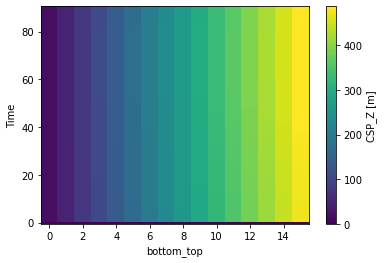

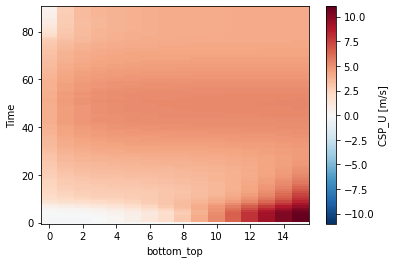

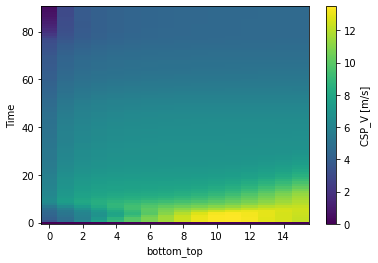

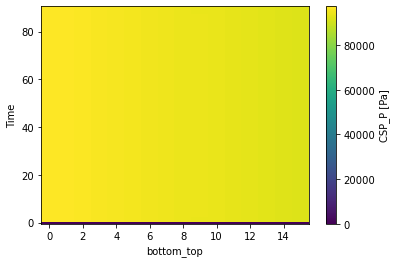

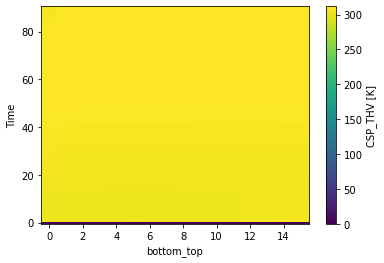

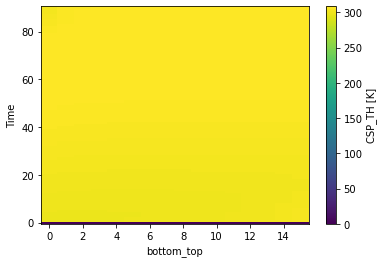

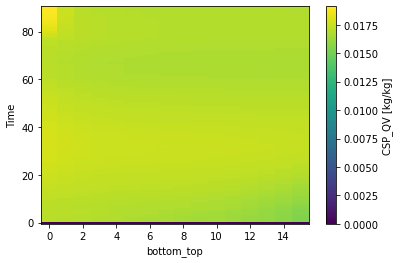

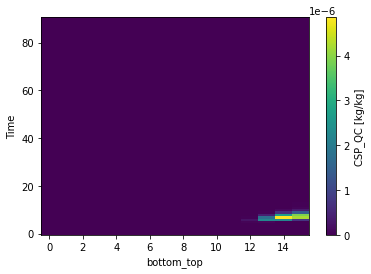

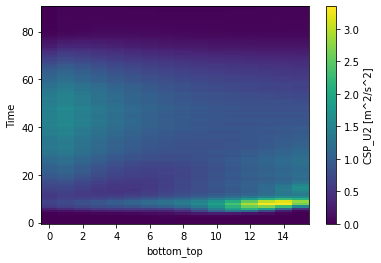

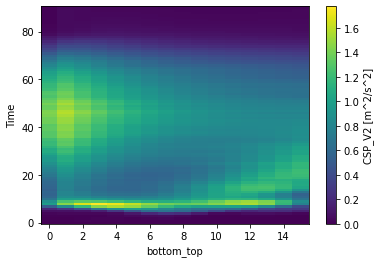

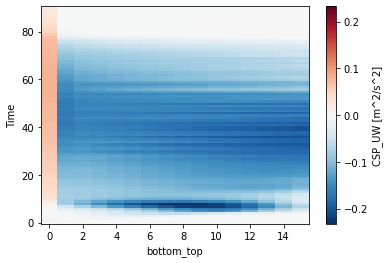

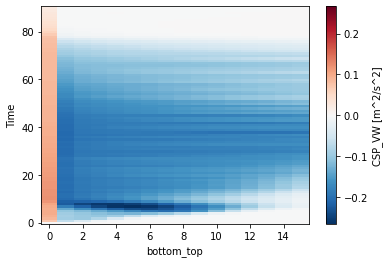

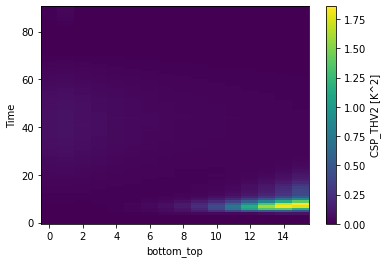

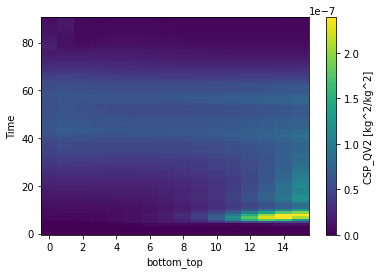

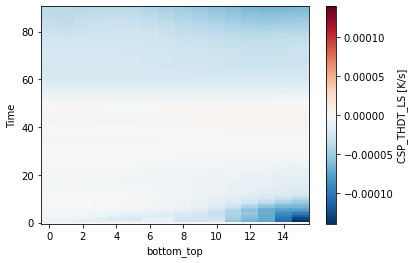

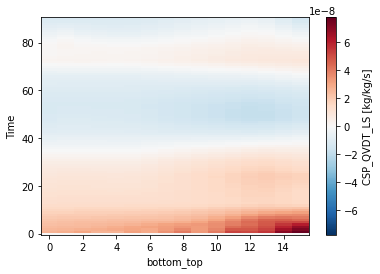

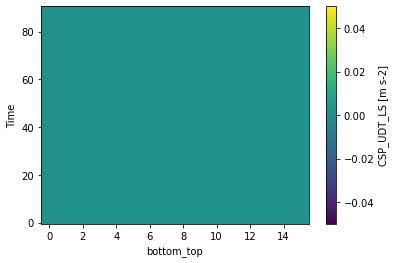

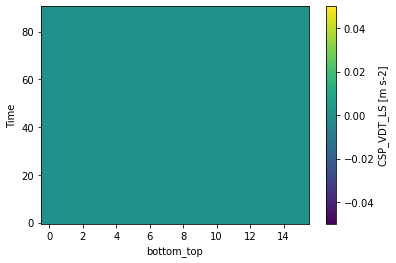

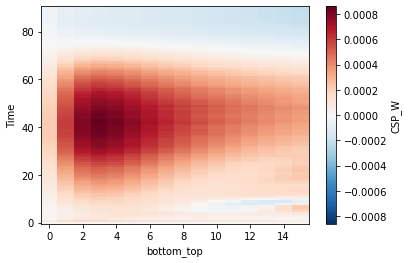

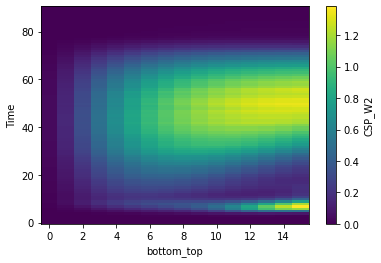

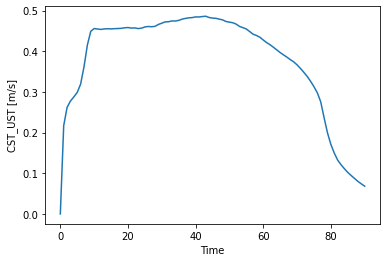

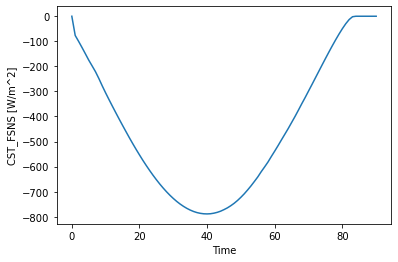

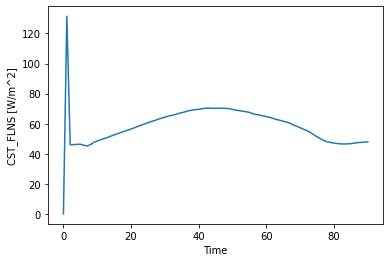

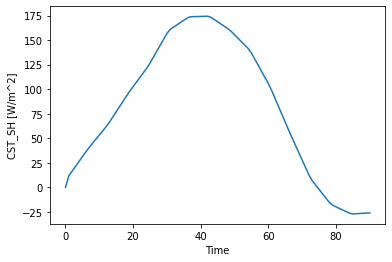

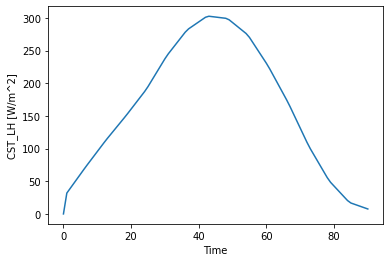

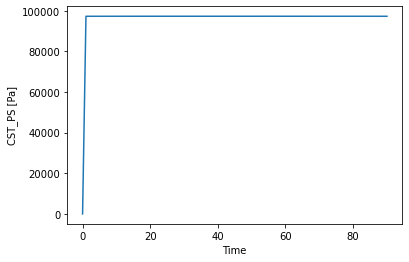

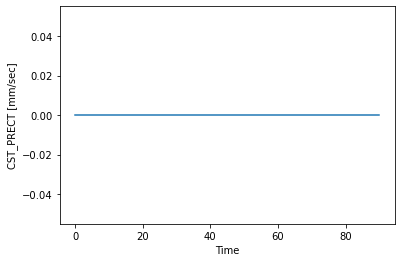

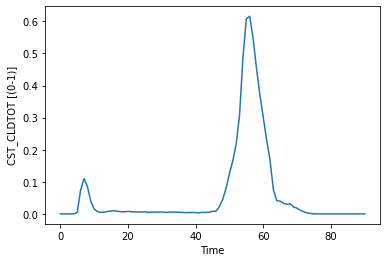

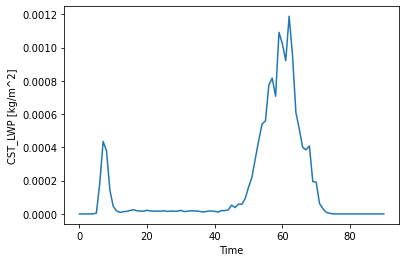

In [27]:
test = xr.open_dataset('/Users/leec813/Downloads/trim_wrfstat/'+'wrfstat2_d01_2019-07-04_12:00:00.nc')

for var in list(test.keys())[:-1]: 
    test[var].plot()
    plt.show()

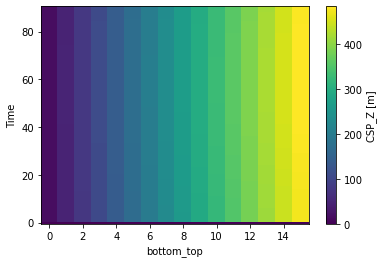

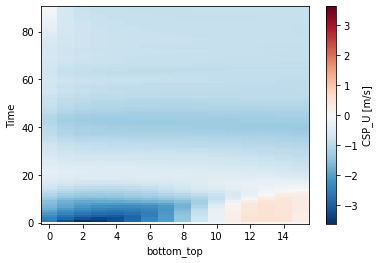

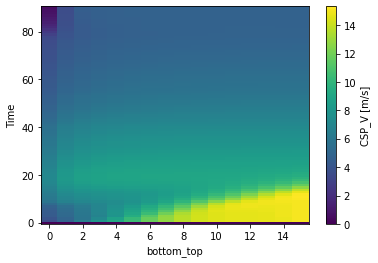

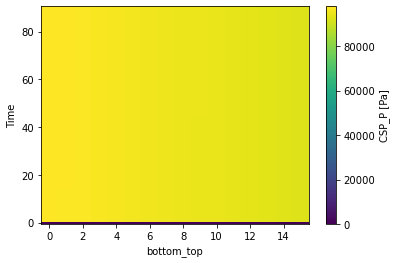

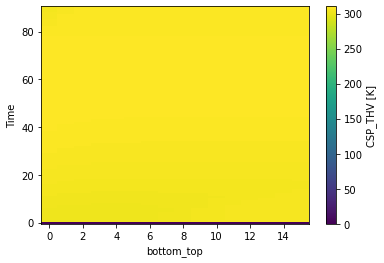

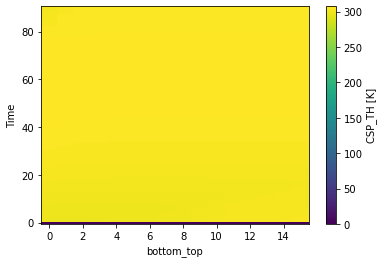

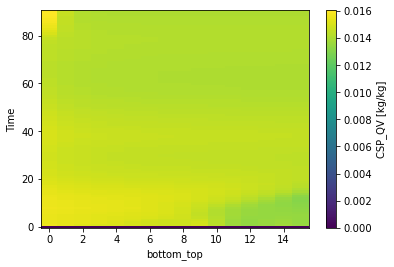

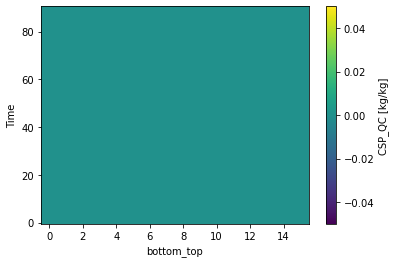

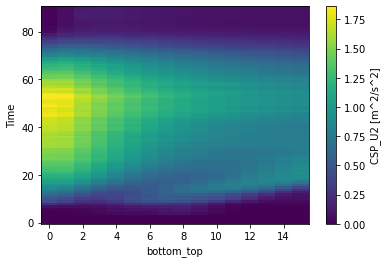

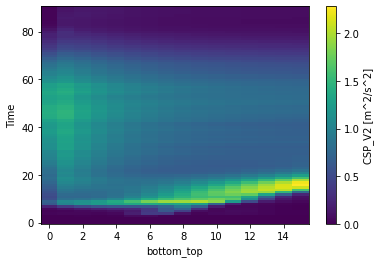

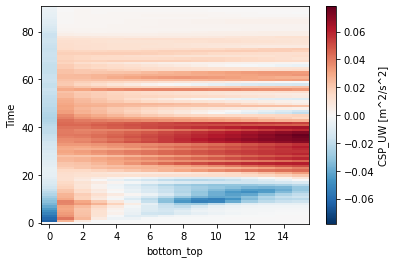

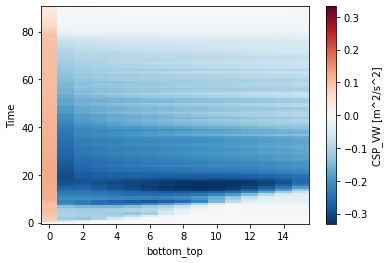

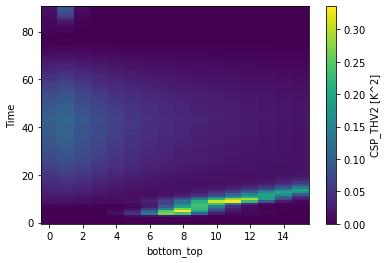

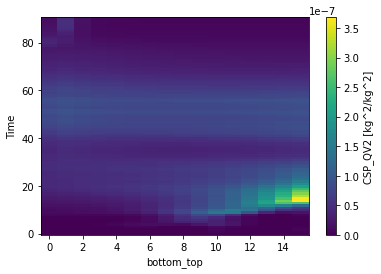

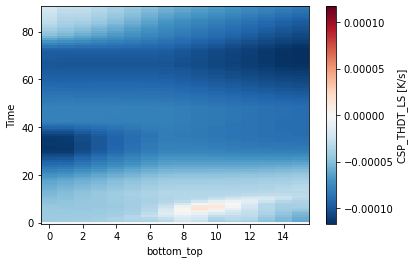

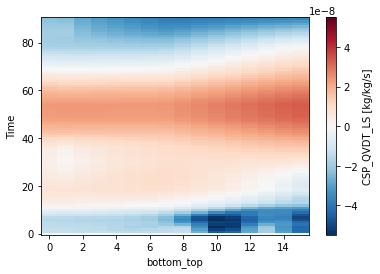

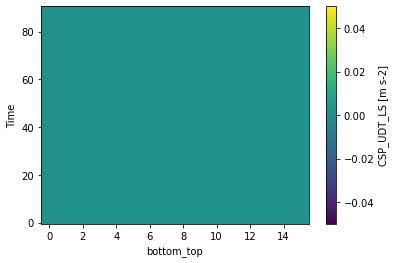

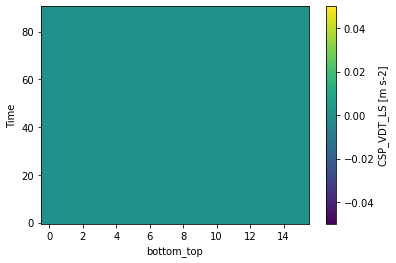

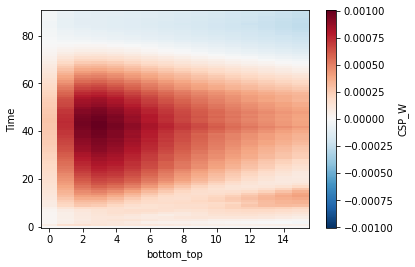

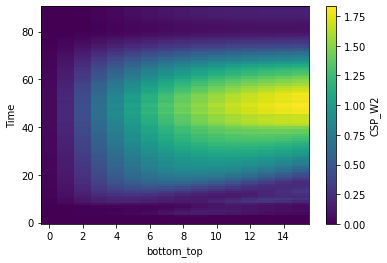

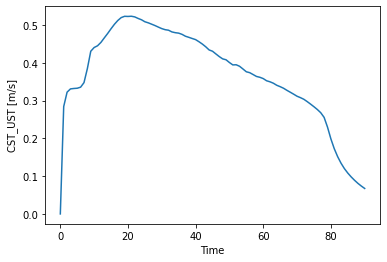

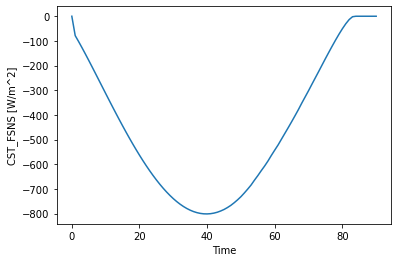

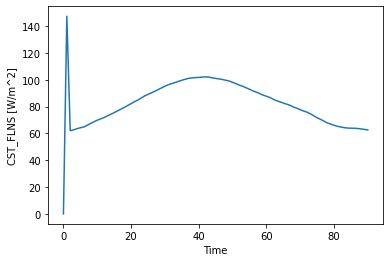

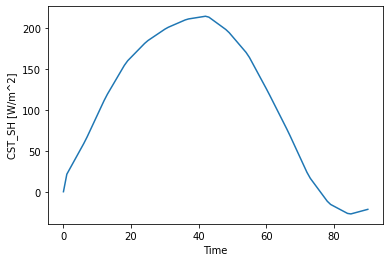

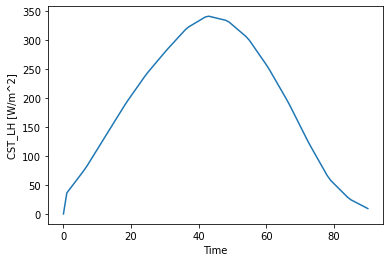

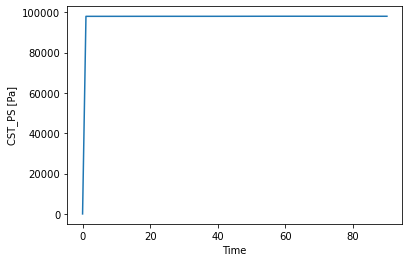

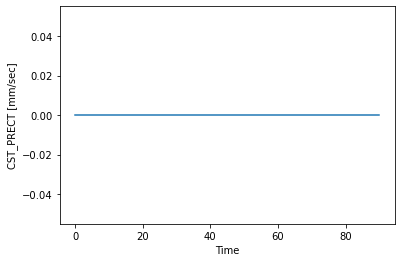

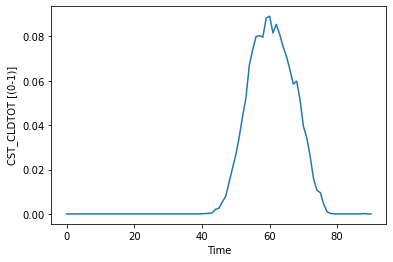

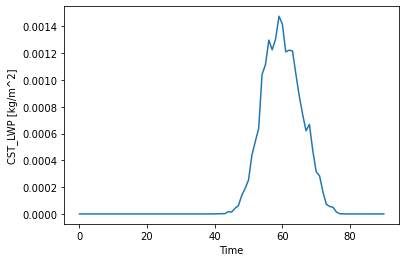

In [28]:
test = xr.open_dataset('/Users/leec813/Downloads/trim_wrfstat/'+'wrfstat2_d01_2018-07-04_12:00:00.nc')

for var in list(test.keys())[:-1]: 
    test[var].plot()
    plt.show()

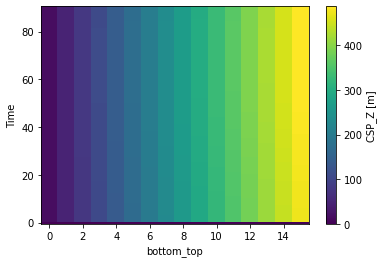

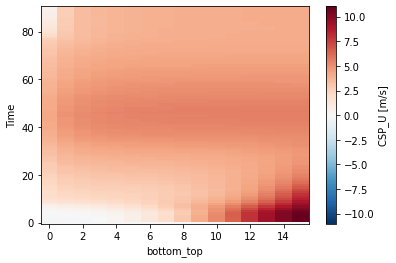

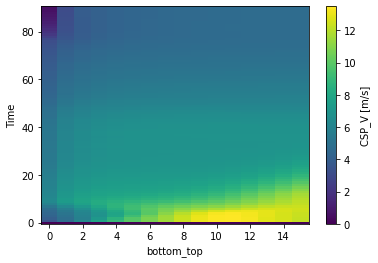

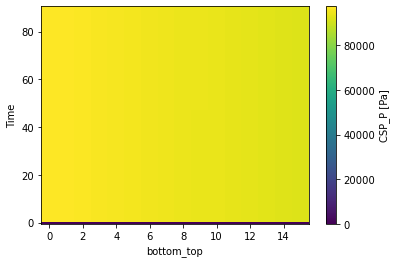

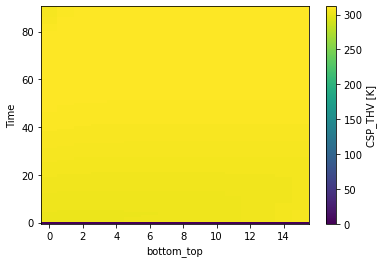

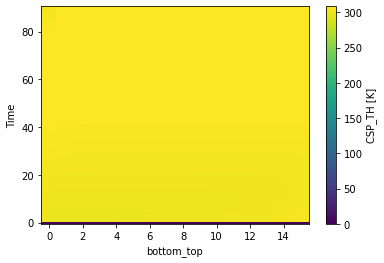

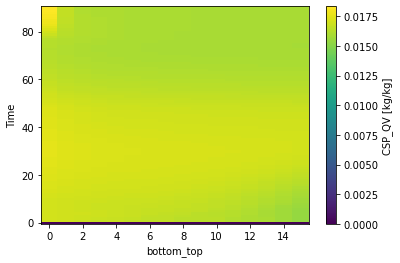

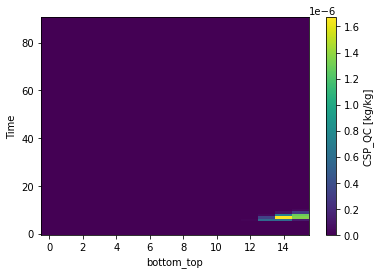

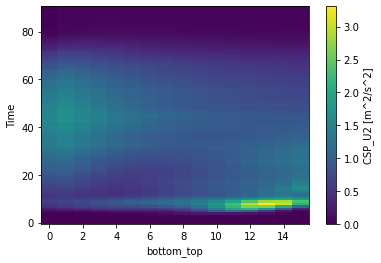

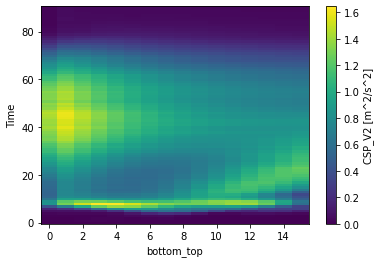

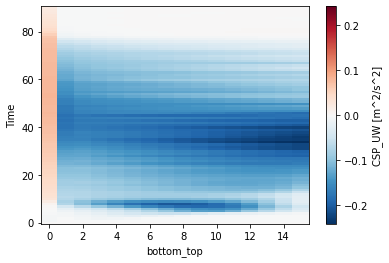

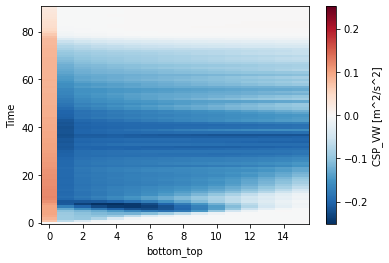

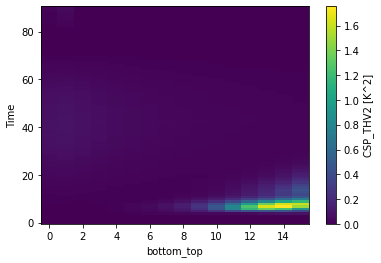

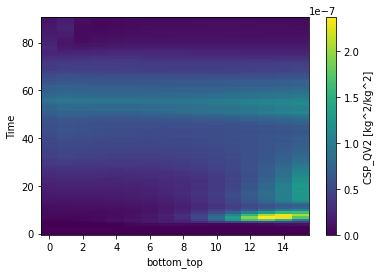

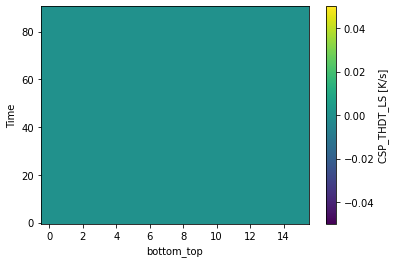

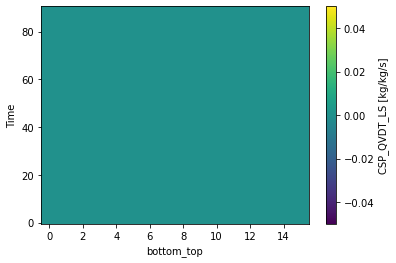

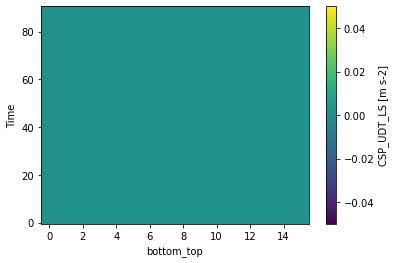

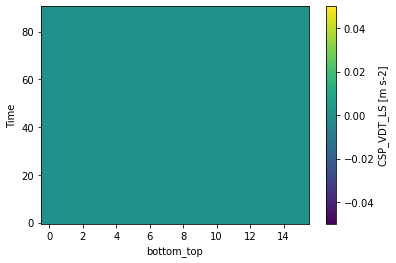

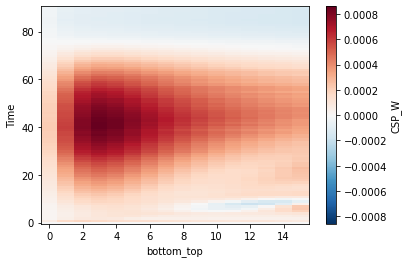

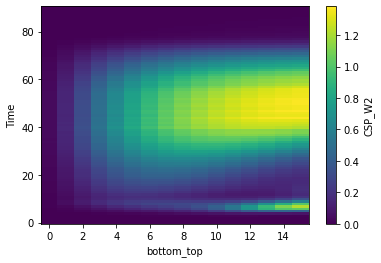

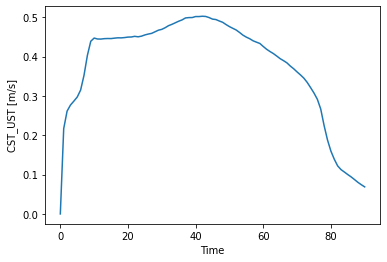

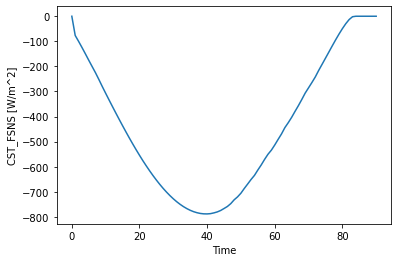

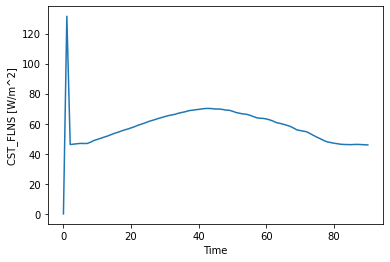

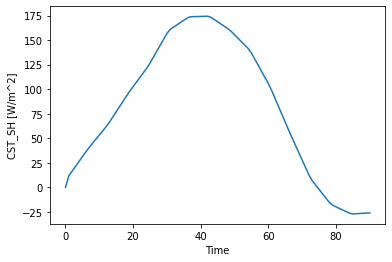

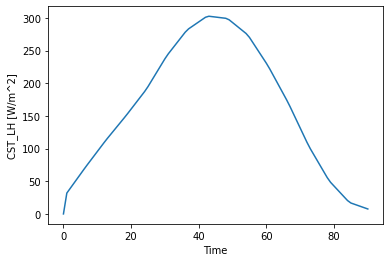

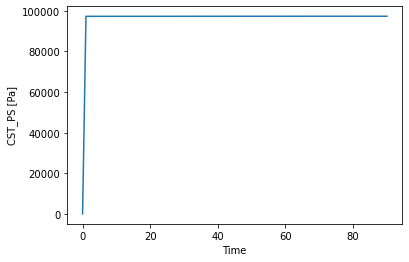

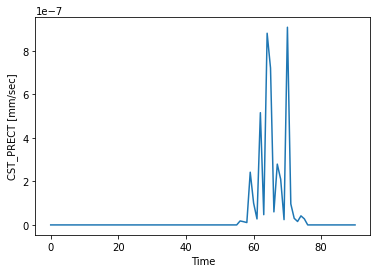

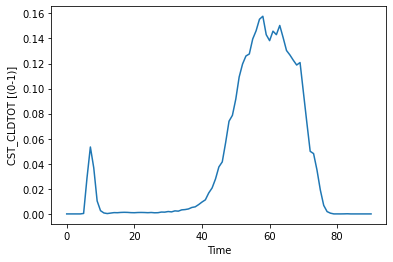

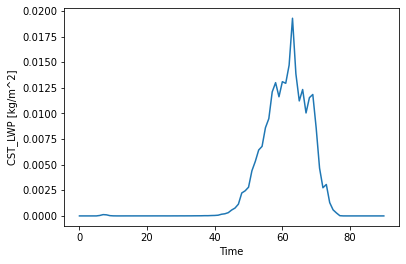

In [29]:
test = xr.open_dataset('/Users/leec813/Downloads/trim_wrfstat/'+'wrfstat1_d01_2019-07-04_12:00:00.nc')

for var in list(test.keys())[:-1]: 
    test[var].plot()
    plt.show()

In [62]:
test = xr.open_dataset('/Users/leec813/Downloads/trim_wrfstat/'+'wrfstat1_d01_2019-07-04_12:00:00.nc')

In [63]:
test['XLAT'].values.squeeze().shape

(91, 250, 250)

1545772

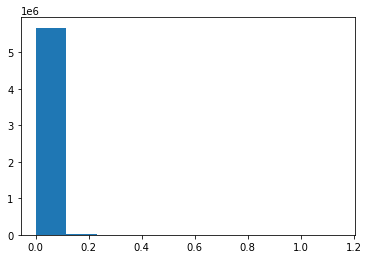

In [64]:
plt.hist(test['XLAT'].values.flatten())
(test['XLAT'].values.flatten() != 0).sum()

(array([5.681566e+06, 4.301000e+03, 9.670000e+02, 3.310000e+02,
        1.850000e+02, 6.600000e+01, 4.400000e+01, 2.400000e+01,
        1.100000e+01, 5.000000e+00]),
 array([0.        , 0.00236877, 0.00473753, 0.0071063 , 0.00947507,
        0.01184384, 0.0142126 , 0.01658137, 0.01895014, 0.0213189 ,
        0.02368767], dtype=float32),
 <BarContainer object of 10 artists>)

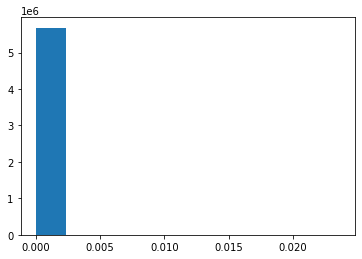

In [57]:
test = xr.open_dataset('/Users/leec813/Downloads/trim_wrfstat/'+'wrfstat1_d01_2018-07-04_12:00:00.nc')
plt.hist(test['XLAT'].values.flatten())

In [61]:
(test['XLAT'].values.flatten() != 0).sum()

94547

In [65]:
test

<xarray.Dataset>
Dimensions:      (Time: 91, bottom_top: 16, south_north: 250, west_east: 250)
Coordinates:
    XLAT         (Time, south_north, west_east) float32 0.0 0.0 0.0 ... 0.0 0.0
    XLONG        (Time, south_north, west_east) float32 ...
    XTIME        (Time) datetime64[ns] ...
Dimensions without coordinates: Time, bottom_top, south_north, west_east
Data variables:
    CSP_Z        (Time, bottom_top) float32 ...
    CSP_U        (Time, bottom_top) float32 ...
    CSP_V        (Time, bottom_top) float32 ...
    CSP_P        (Time, bottom_top) float32 ...
    CSP_THV      (Time, bottom_top) float32 ...
    CSP_TH       (Time, bottom_top) float32 ...
    CSP_QV       (Time, bottom_top) float32 ...
    CSP_QC       (Time, bottom_top) float32 ...
    CSP_U2       (Time, bottom_top) float32 ...
    CSP_V2       (Time, bottom_top) float32 ...
    CSP_UW       (Time, bottom_top) float32 ...
    CSP_VW       (Time, bottom_top) float32 ...
    CSP_THV2     (Time, bottom_top) float32 ...
    CSP_QV2      (Time, bottom_top) float32 ...
    CSP_THDT_LS  (Time, bottom_top) float32 ...
    CSP_QVDT_LS  (Time, bottom_top) float32 ...
    CSP_UDT_LS   (Time, bottom_top) float32 ...
    CSP_VDT_LS   (Time, bottom_top) float32 ...
    CSP_W        (Time, bottom_top) float32 ...
    CSP_W2       (Time, bottom_top) float32 ...
    CST_UST      (Time) float32 ...
    CST_FSNS     (Time) float32 ...
    CST_FLNS     (Time) float32 ...
    CST_SH       (Time) float32 ...
    CST_LH       (Time) float32 ...
    CST_PS       (Time) float32 ...
    CST_PRECT    (Time) float32 ...
    CST_CLDTOT   (Time) float32 ...
    CST_LWP      (Time) float32 ...
    Times        (Time) |S19 ...
Attributes:
    TITLE:                                  OUTPUT FROM WRF V3.8.1 MODEL
    START_DATE:                            2019-07-04_12:00:00
    WEST-EAST_GRID_DIMENSION:              251
    SOUTH-NORTH_GRID_DIMENSION:            251
    BOTTOM-TOP_GRID_DIMENSION:             227
    DX:                                    100.0
    DY:                                    100.0
    GRIDTYPE:                              C
    DIFF_OPT:                              2
    KM_OPT:                                2
    DAMP_OPT:                              3
    DAMPCOEF:                              0.2
    KHDIF:                                 1.0
    KVDIF:                                 1.0
    MP_PHYSICS:                            8
    RA_LW_PHYSICS:                         4
    RA_SW_PHYSICS:                         4
    SF_SFCLAY_PHYSICS:                     1
    SF_SURFACE_PHYSICS:                    1
    BL_PBL_PHYSICS:                        0
    CU_PHYSICS:                            0
    SF_LAKE_PHYSICS:                       0
    SURFACE_INPUT_SOURCE:                  3
    SST_UPDATE:                            0
    GRID_FDDA:                             0
    GFDDA_INTERVAL_M:                      0
    GFDDA_END_H:                           0
    GRID_SFDDA:                            0
    SGFDDA_INTERVAL_M:                     0
    SGFDDA_END_H:                          0
    HYPSOMETRIC_OPT:                       1
    USE_THETA_M:                           1
    WEST-EAST_PATCH_START_UNSTAG:          1
    WEST-EAST_PATCH_END_UNSTAG:            250
    WEST-EAST_PATCH_START_STAG:            1
    WEST-EAST_PATCH_END_STAG:              251
    SOUTH-NORTH_PATCH_START_UNSTAG:        1
    SOUTH-NORTH_PATCH_END_UNSTAG:          250
    SOUTH-NORTH_PATCH_START_STAG:          1
    SOUTH-NORTH_PATCH_END_STAG:            251
    BOTTOM-TOP_PATCH_START_UNSTAG:         1
    BOTTOM-TOP_PATCH_END_UNSTAG:           226
    BOTTOM-TOP_PATCH_START_STAG:           1
    BOTTOM-TOP_PATCH_END_STAG:             227
    GRID_ID:                               1
    PARENT_ID:                             0
    I_PARENT_START:                        0
    J_PARENT_START:                        0
    PARENT_GRID_RATIO:                     1
    DT: 

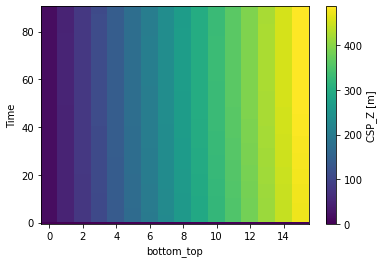

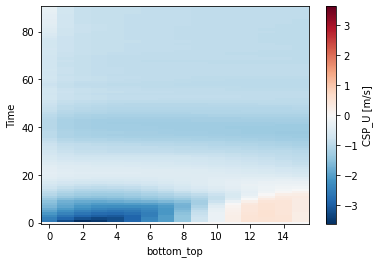

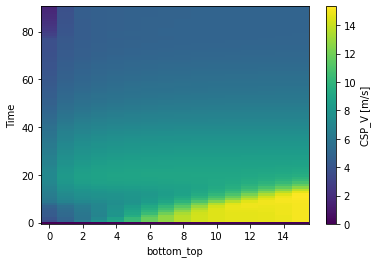

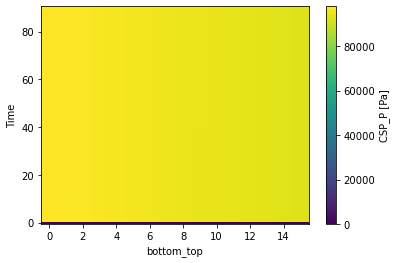

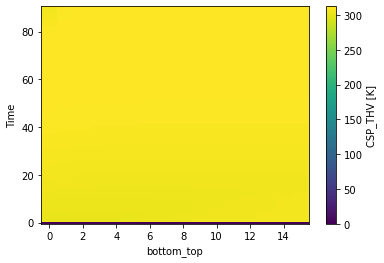

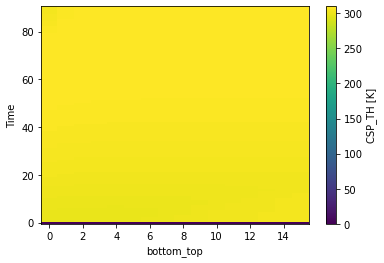

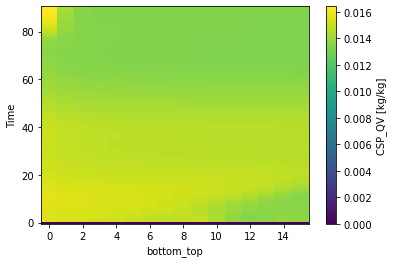

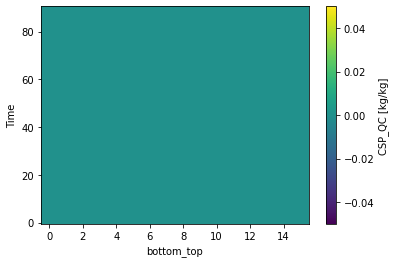

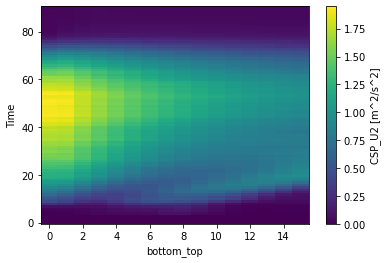

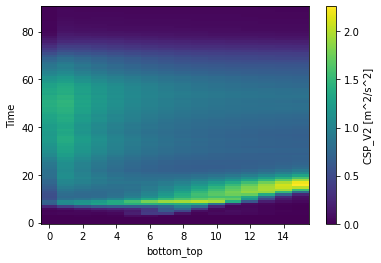

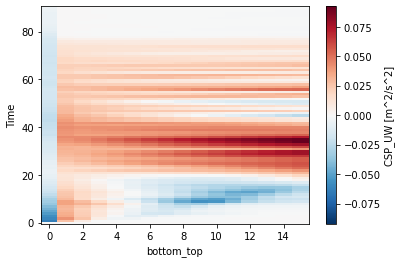

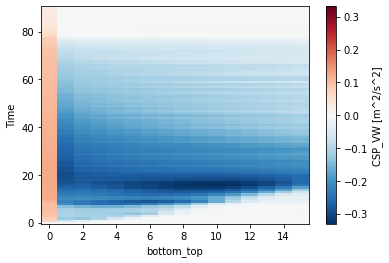

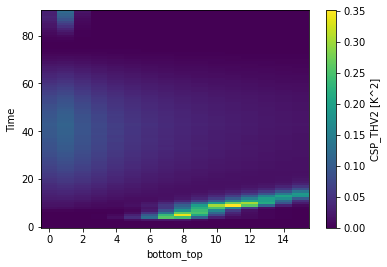

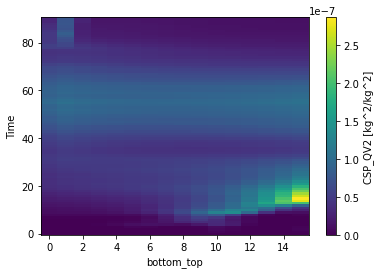

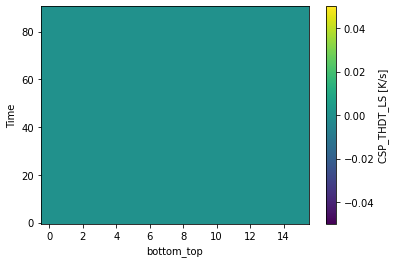

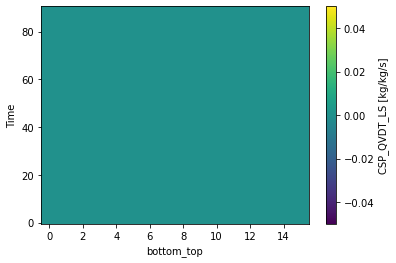

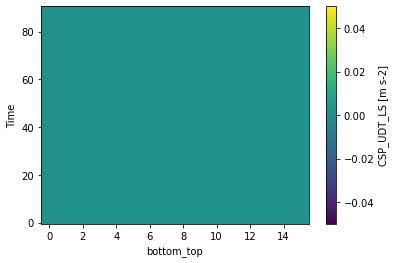

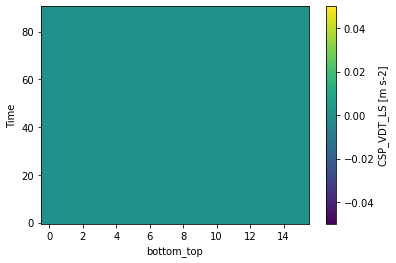

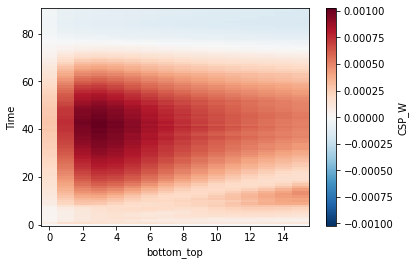

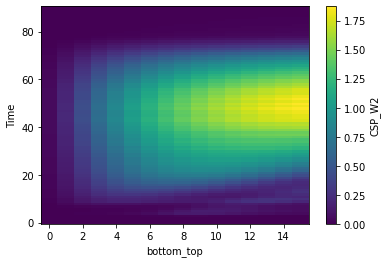

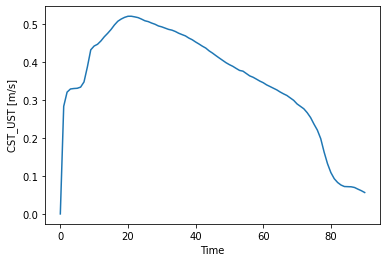

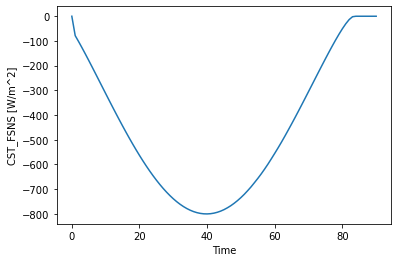

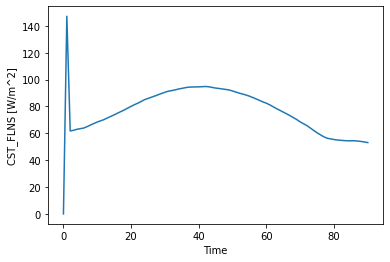

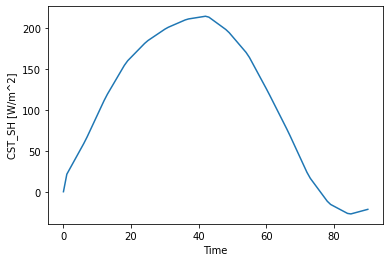

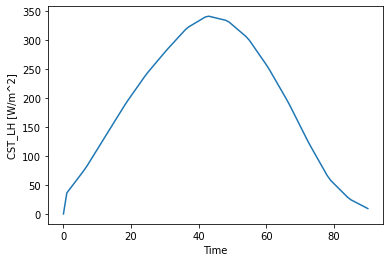

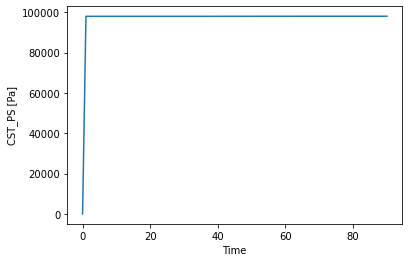

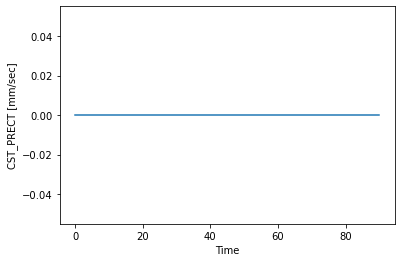

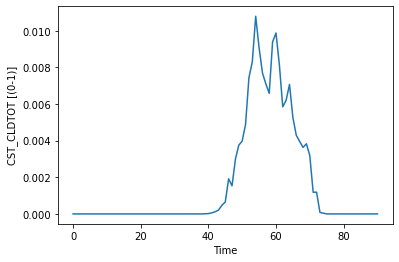

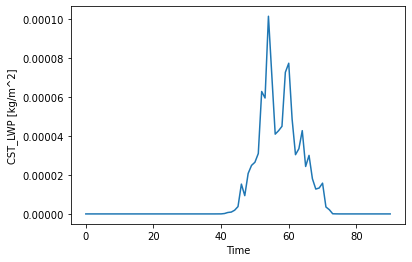

In [30]:
test = xr.open_dataset('/Users/leec813/Downloads/trim_wrfstat/'+'wrfstat1_d01_2018-07-04_12:00:00.nc')

for var in list(test.keys())[:-1]: 
    test[var].plot()
    plt.show()

In [38]:
test['XLAT'].values

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

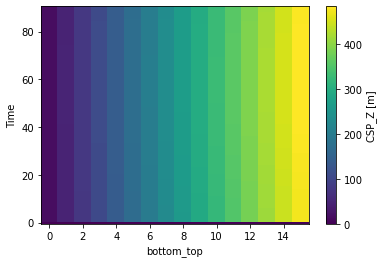

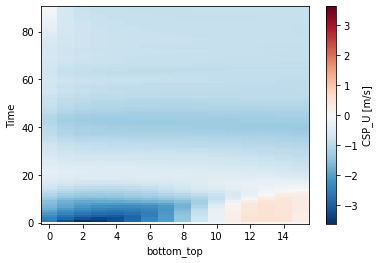

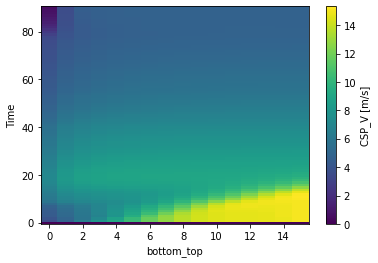

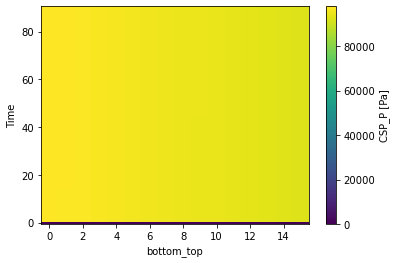

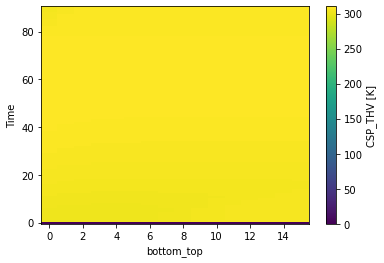

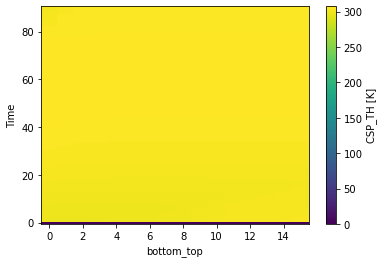

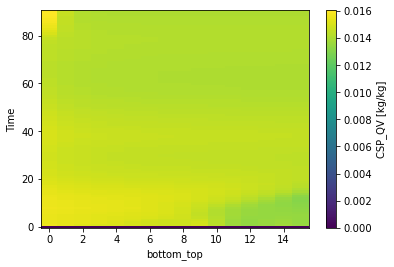

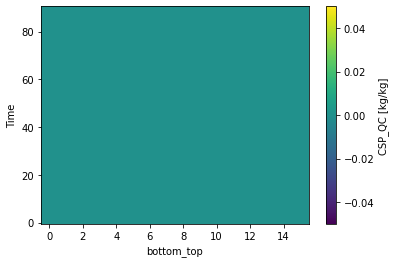

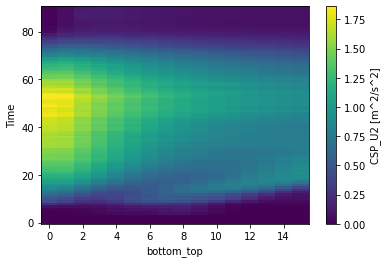

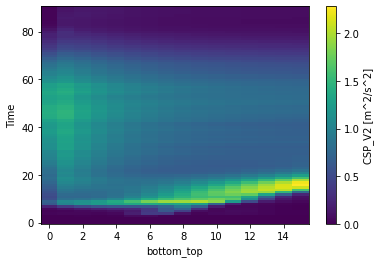

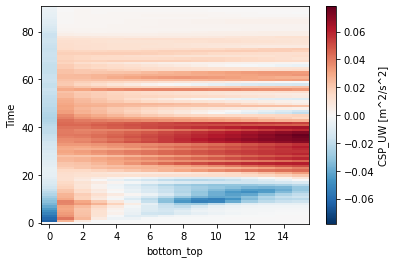

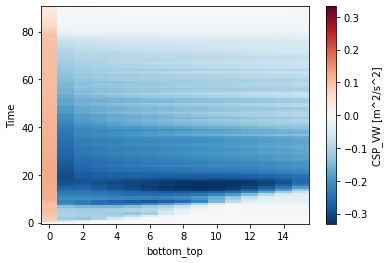

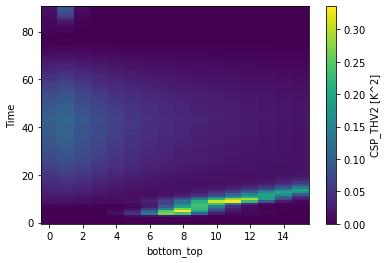

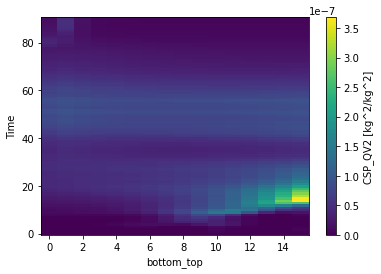

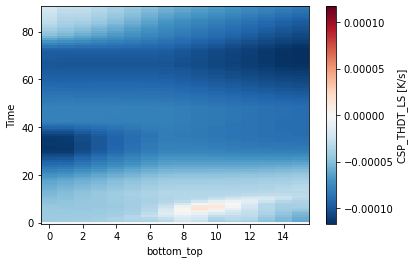

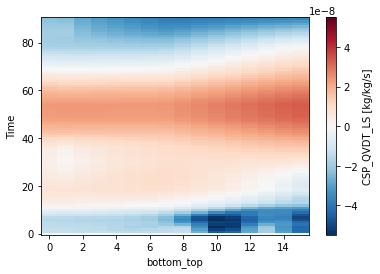

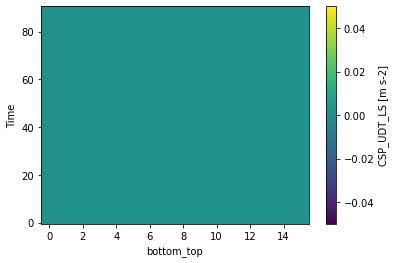

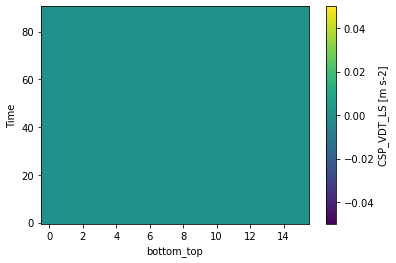

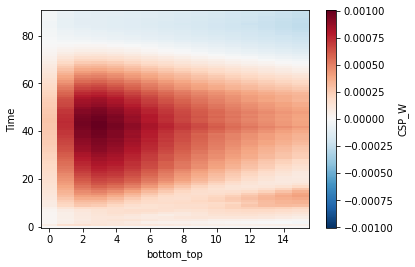

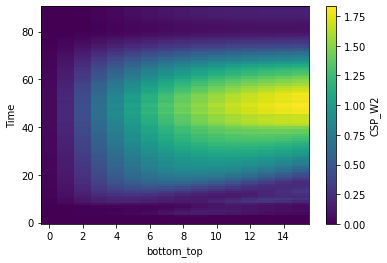

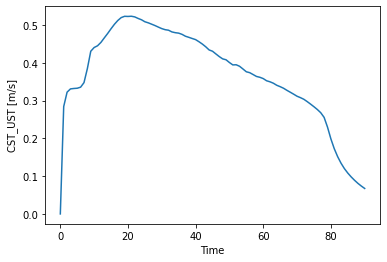

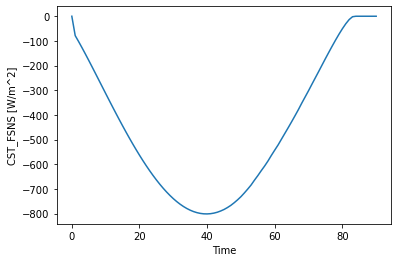

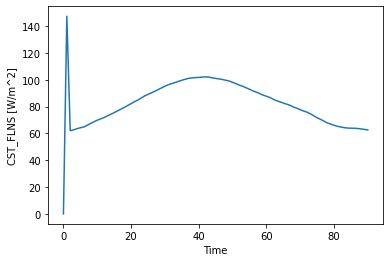

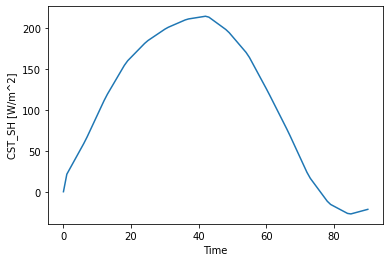

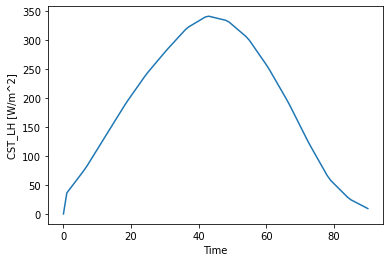

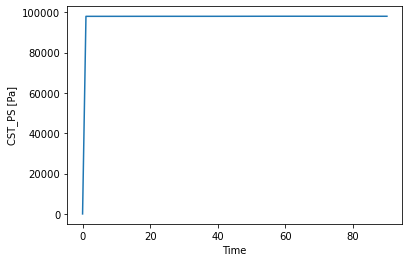

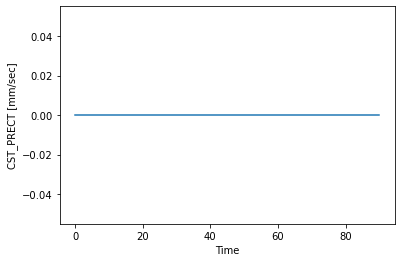

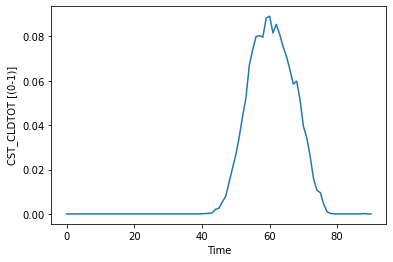

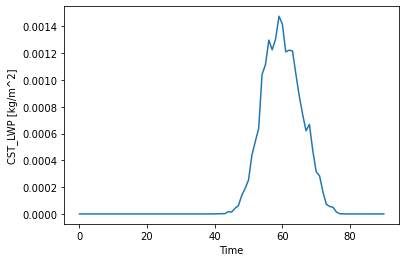

In [26]:
for var in list(test.keys())[:-1]: 
    test[var].plot()
    plt.show()

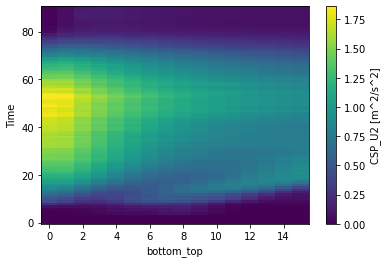

In [17]:
test['CSP_U2'].plot()